---
title: "Fake News Classification"
image: fakenews.jpeg
format:
  html:
    toc: true
author: "Jun Ryu"
date: "2023-03-15"
categories: [python, ML, tensorflow]
---

> Rampant misinformation — often called “fake news” — is one of the defining features of contemporary democratic life. 

In this post, we will develop and assess a fake news classifier using Tensorflow.

# 1. Acquiring Training Data

First, we import all the necessary packages and read in the data. We will also import stopwords (a word that is usually considered to be uninformative, such as “the,” “and,” or “but"), which we will use later.

Each row of the data corresponds to an article. The `title` column gives the title of the article, while the `text` column gives the full article text. The final column, called `fake`, is `0` if the article is true and `1` if the article contains fake news, as determined by the authors of the paper above.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding visualization
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
train_df = pd.read_csv(train_url)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0
...,...,...,...,...
22444,10709,ALARMING: NSA Refuses to Release Clinton-Lynch...,If Clinton and Lynch just talked about grandki...,1
22445,8731,Can Pence's vow not to sling mud survive a Tru...,"() - In 1990, during a close and bitter congre...",0
22446,4733,Watch Trump Campaign Try To Spin Their Way Ou...,A new ad by the Hillary Clinton SuperPac Prior...,1
22447,3993,"Trump celebrates first 100 days as president, ...","HARRISBURG, Pa.U.S. President Donald Trump hit...",0


# 2. Making a Dataset

In this part, we will write a function called `make_dataset()`, which accomplishes two things:

* Remove stopwords from `title` and `text` columns.
* Construct and return a `tf.data.Dataset` with two inputs and one output. The input should be of the form `(title, text)`, and the output should consist only of the `fake` column.

Then, we will call this function on the training dataframe, then split 20% of the output to use for validation.

In [2]:
def make_dataset(df):
  # remove stopwords
  df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  # create Dataset
  Dataset = tf.data.Dataset.from_tensor_slices(({
      "title" : df[["title"]],
      "text" : df[["text"]]
  }, {
      "fake" : df["fake"]
  }))

  # batch our Dataset to increase training speed
  Dataset = Dataset.batch(100)
  return Dataset

data = make_dataset(train_df)
data = data.shuffle(buffer_size = len(data))

train_size = int(0.8*len(data)) # split Dataset
val_size   = int(0.2*len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

Now, we will calculate the base rate for the model.

In [3]:
train_df["fake"].value_counts()

1    11740
0    10709
Name: fake, dtype: int64

Our base model will always guess the most frequent label (or `1`, in this case). This will result in the base rate of $\frac{11740}{11740+10709}$ or approximately $52.3\%$.

To improve this rate, we will prepare a text vectorization layer that we can implement in our models.

In [4]:
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

title_vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))

text_vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

# 3. Create Models

We aim to create three models to answer the following question:

> When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?

All three models will be utilizing the Functional API.

First, we will define our inputs `title_input` and `text_input` below.

In [5]:
title_input = keras.Input(
    shape=(1,),
    name = "title", # same name as the dictionary key in the dataset
    dtype = "string"
)

text_input = keras.Input(
    shape=(1,),
    name = "text",
    dtype = "string"
)

## First Model

The first model will only make use of the article's title.

In [6]:
title_features = title_vectorize_layer(title_input) # apply this TextVectorization layer to title_input

# use embeddings
title_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(2, activation='relu', name="fake")(title_features)

In [7]:
# only using title
model1 = keras.Model(
    inputs = [title_input],
    outputs = title_features
)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout (Dropout)           (None, 500, 3)            0         
                                                                 
 global_average_pooling1d (G  (None, 3)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0     

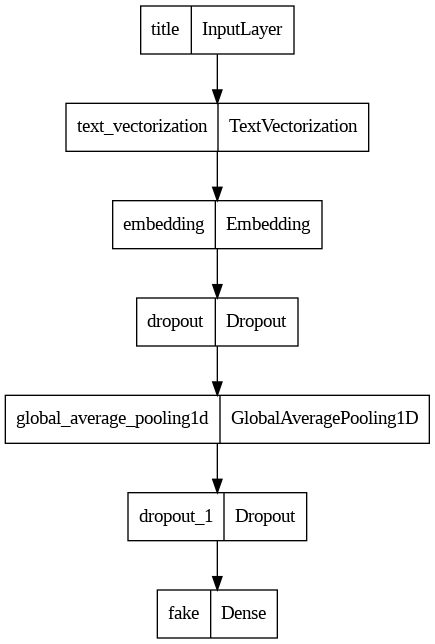

In [8]:
from tensorflow.keras import utils
utils.plot_model(model1)

In [9]:
model1.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [10]:
history = model1.fit(train,
                    validation_data=val,
                    epochs = 20,
                    verbose = True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 16s 80ms/step - loss: 0.6918 - accuracy: 0.5203 - val_loss: 0.6897 - val_accuracy: 0.5185
Epoch 2/20
180/180 [==============================] - 2s 10ms/step - loss: 0.6875 - accuracy: 0.5275 - val_loss: 0.6846 - val_accuracy: 0.5218
Epoch 3/20
180/180 [==============================] - 2s 13ms/step - loss: 0.6812 - accuracy: 0.5610 - val_loss: 0.6769 - val_accuracy: 0.5269
Epoch 4/20
180/180 [==============================] - 1s 7ms/step - loss: 0.6728 - accuracy: 0.6529 - val_loss: 0.6668 - val_accuracy: 0.6233
Epoch 5/20
180/180 [==============================] - 1s 6ms/step - loss: 0.6613 - accuracy: 0.7581 - val_loss: 0.6555 - val_accuracy: 0.8844
Epoch 6/20
180/180 [==============================] - 1s 6ms/step - loss: 0.6481 - accuracy: 0.8375 - val_loss: 0.6398 - val_accuracy: 0.9299
Epoch 7/20
180/180 [==============================] - 1s 6ms/step - loss: 0.6331 - accuracy: 0.8570 - val_loss: 0.6253 - val_accuracy: 0.9293
Epoch 8/20
18

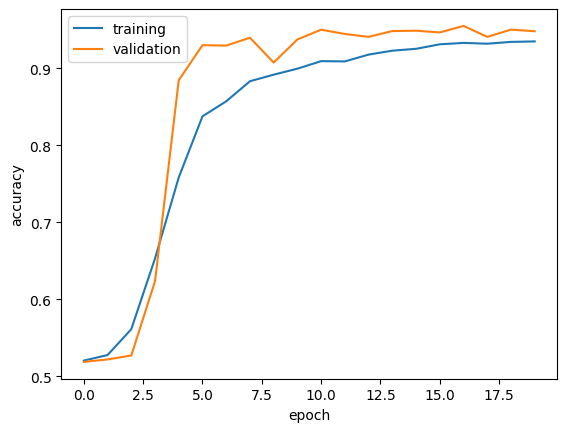

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

We observe that the validation accuracy stabilized between 93% and 95%.

## Second Model

The second model will only make use of the article's text.

In [12]:
text_features = text_vectorize_layer(text_input)
text_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(2, activation='relu', name="fake")(text_features)

In [13]:
model2 = keras.Model(
    # only using text
    inputs = [text_input],
    outputs = text_features
)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout_2 (Dropout)         (None, 500, 3)            0         
                                                                 
 global_average_pooling1d_1   (None, 3)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0   

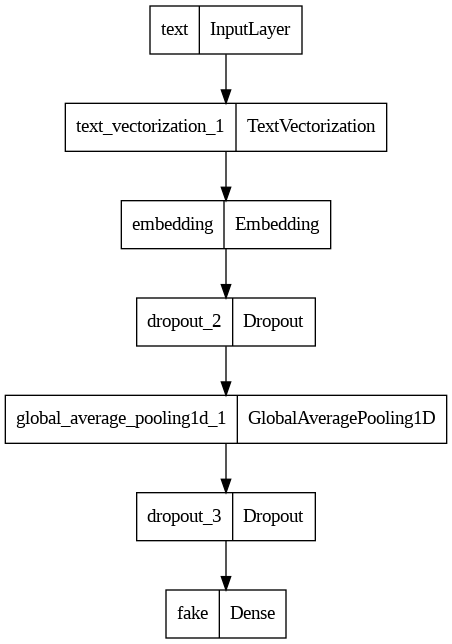

In [14]:
from tensorflow.keras import utils
utils.plot_model(model2)

In [15]:
model2.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [16]:
history = model2.fit(train,
                    validation_data=val,
                    epochs = 20,
                    verbose = True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 17s 88ms/step - loss: 0.6833 - accuracy: 0.5435 - val_loss: 0.6697 - val_accuracy: 0.6138
Epoch 2/20
180/180 [==============================] - 4s 19ms/step - loss: 0.6525 - accuracy: 0.7093 - val_loss: 0.6291 - val_accuracy: 0.7724
Epoch 3/20
180/180 [==============================] - 2s 12ms/step - loss: 0.6088 - accuracy: 0.8028 - val_loss: 0.5825 - val_accuracy: 0.8911
Epoch 4/20
180/180 [==============================] - 3s 18ms/step - loss: 0.5618 - accuracy: 0.8608 - val_loss: 0.5288 - val_accuracy: 0.9319
Epoch 5/20
180/180 [==============================] - 2s 11ms/step - loss: 0.5140 - accuracy: 0.8945 - val_loss: 0.4845 - val_accuracy: 0.9213
Epoch 6/20
180/180 [==============================] - 2s 12ms/step - loss: 0.4703 - accuracy: 0.9075 - val_loss: 0.4399 - val_accuracy: 0.9393
Epoch 7/20
180/180 [==============================] - 3s 15ms/step - loss: 0.4292 - accuracy: 0.9166 - val_loss: 0.4058 - val_accuracy: 0.9371
Epoch 8/2

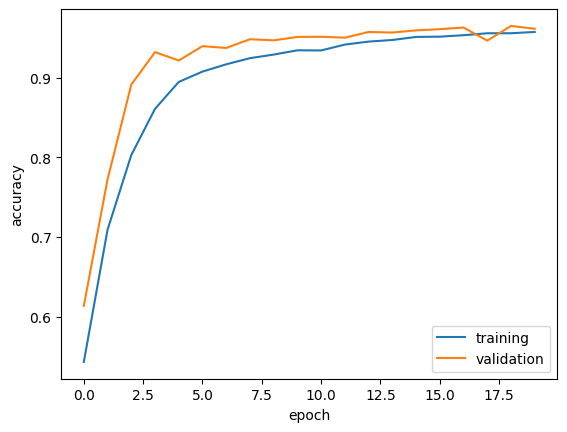

In [17]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

We observe that the validation accuracy stabilized between 95% and 97%.

## Third Model

The third model will only make use of **both** the article's title and text.

In [18]:
title_features = title_vectorize_layer(title_input)
text_features = text_vectorize_layer(text_input)

# share an embedding layer
shared_embedding = layers.Embedding(size_vocabulary, 10)
title_features = shared_embedding(title_features)
text_features = shared_embedding(text_features)
title_features = layers.Dense(32, activation='relu')(title_features)
text_features = layers.Dense(32, activation='relu')(text_features)

main = layers.concatenate([title_features, text_features], axis = 1)
main = layers.Dropout(0.2)(main)
main = layers.GlobalAveragePooling1D()(main)
main = layers.Dropout(0.2)(main)
main = layers.Dense(2, activation='relu', name = 'fake')(main)


In [19]:
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = main
)

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 500)         0           ['title[0][0]']                  
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 500)         0           ['text[0][0]']             

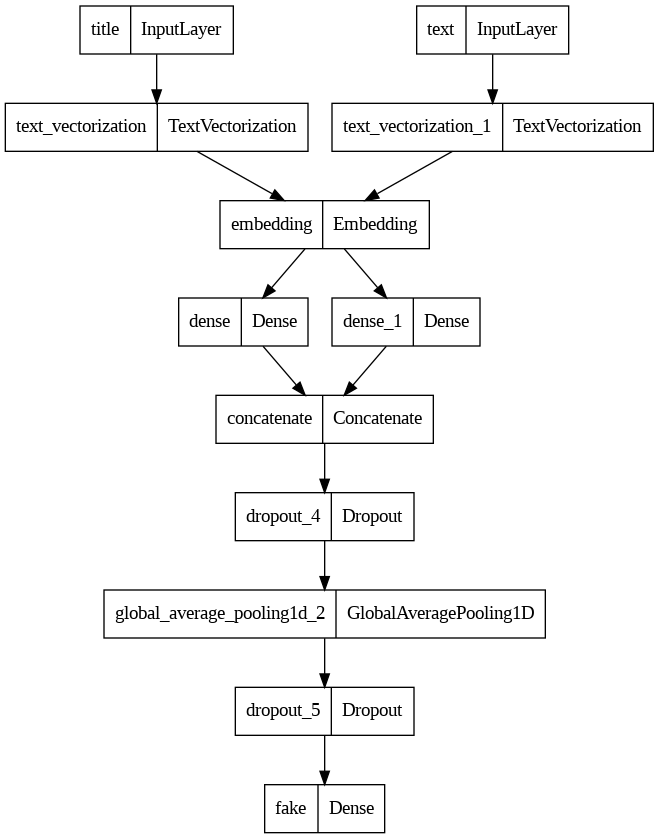

In [20]:
keras.utils.plot_model(model3)

In [21]:
model3.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [22]:
history = model3.fit(train,
                    validation_data=val,
                    epochs = 20,
                    verbose = True)

Epoch 1/20
180/180 [==============================] - 18s 88ms/step - loss: 0.6790 - accuracy: 0.5439 - val_loss: 0.6346 - val_accuracy: 0.6862
Epoch 2/20
180/180 [==============================] - 4s 20ms/step - loss: 0.5197 - accuracy: 0.8429 - val_loss: 0.3826 - val_accuracy: 0.9176
Epoch 3/20
180/180 [==============================] - 3s 16ms/step - loss: 0.3240 - accuracy: 0.9160 - val_loss: 0.2372 - val_accuracy: 0.9567
Epoch 4/20
180/180 [==============================] - 3s 17ms/step - loss: 0.2416 - accuracy: 0.9345 - val_loss: 0.1888 - val_accuracy: 0.9584
Epoch 5/20
180/180 [==============================] - 3s 16ms/step - loss: 0.1980 - accuracy: 0.9488 - val_loss: 0.1531 - val_accuracy: 0.9649
Epoch 6/20
180/180 [==============================] - 3s 16ms/step - loss: 0.1694 - accuracy: 0.9574 - val_loss: 0.1284 - val_accuracy: 0.9726
Epoch 7/20
180/180 [==============================] - 4s 21ms/step - loss: 0.1532 - accuracy: 0.9605 - val_loss: 0.1162 - val_accuracy: 0.977

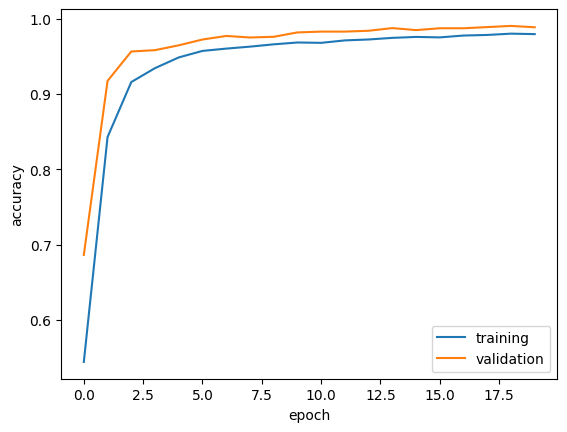

In [23]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

We observe that the validation accuracy stabilized between 97% and 99%.

# 4. Best Model Evaluation

Using the best model (the third model), we will test the model performance on unseen test data. First, we will need to convert the dataset using the function `make_dataset()` defined in Part 2.

In [24]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_df = pd.read_csv(test_url)
test = make_dataset(test_df)

model3.evaluate(test, verbose=1)

225/225 [==============================] - 3s 15ms/step - loss: 0.0578 - accuracy: 0.9848


[0.057782068848609924, 0.9848099946975708]

We get 98.48% as our accuracy. That is impressive!

# 5. Embedding Visualization

Lastly, we will visualize our embedding layer from the best model. To achieve this, we will use principal component analysis (PCA) to reduce the dimension down. In particular, we will create a 2-dimensional embedding plot.

In [ ]:
weights = model3.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = title_vectorize_layer.get_vocabulary() # get the vocabulary from our data prep for later

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [ ]:
import plotly.express as px
fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = [2]*len(embedding_df),
                 hover_name = "word")

fig.show()

Unfortunately, the plot was not rendered through Quarto, so I have screenshotted the visualization from Google Colab (attached below).

![](embeddings.png)